<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/DenisRang/a1-simulated-annealing-and-sampling/blob/master/a1_task1.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

### Import common packages

In [1]:
import numpy as np
import numpy.random as rn
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import copy
import time

### Observe Iris dataset

In [2]:
from sklearn.datasets import load_iris
    
# Load the Iris dataset
iris_dataset = load_iris()

print('The feature values for Obs 0 are: ', iris_dataset.data[0])
print('The feature names are: ', iris_dataset.feature_names)
print('The target value for Obs 0 is:', iris_dataset.target[0])
print('The target name for Obs 0 is:', iris_dataset.target_names[iris_dataset.target[0]])
print('The minimum values of the four features are:', np.min(iris_dataset.data, axis = 0))
print('The maximum values of the four features are:', np.max(iris_dataset.data, axis = 0))
print('The unique target values are:', np.unique(iris_dataset.target))

The feature values for Obs 0 are:  [5.1 3.5 1.4 0.2]
The feature names are:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
The target value for Obs 0 is: 0
The target name for Obs 0 is: setosa
The minimum values of the four features are: [4.3 2.  1.  0.1]
The maximum values of the four features are: [7.9 4.4 6.9 2.5]
The unique target values are: [0 1 2]


In [0]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


NUM_CLASSES = 3

X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris_dataset.data, iris_dataset.target)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

### Define the model

In [0]:
def build_model():
  model = keras.models.Sequential([
    keras.layers.Dense(5, activation="relu", use_bias=False, input_shape=X_train.shape[1:]),
    keras.layers.Dense(5, activation="relu", use_bias=False),
    keras.layers.Dense(NUM_CLASSES, activation="softmax",use_bias=False)
  ])
  opt = keras.optimizers.SGD(lr=.01)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

  return model

def evaluate_model_state(weights):
  model.set_weights(weights)
  train_evaluating = model.evaluate(X_train,y_train,batch_size=X_train.shape[0],verbose=0)
  test_evaluating = model.evaluate(X_test,y_test,batch_size=X_test.shape[0],verbose=0)
  print(f'Train loss: {train_evaluating[0]:.3f}, accuracy: {train_evaluating[1]:.3f}')
  print(f'Test loss: {test_evaluating[0]:.3f}, accuracy: {test_evaluating[1]:.3f}')

In [127]:
model = build_model()
model.summary()
initial_weights = model.get_weights()
evaluate_model_state(initial_weights)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 5)                 20        
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 25        
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 15        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
Train loss: 0.858, accuracy: 0.357
Test loss: 1.002, accuracy: 0.263


### By default, Keras uses Glorot initialization with a uniform distribution



In [145]:
print(initial_weights)

[array([[ 0.22054231,  0.22916901,  0.07192302, -0.8043059 , -0.498211  ],
       [-0.6238756 ,  0.55699134,  0.6127715 ,  0.09454632, -0.38827342],
       [ 0.42361486, -0.6964945 ,  0.42162454, -0.04250377, -0.16968489],
       [-0.765055  ,  0.19359207,  0.52382755, -0.6470417 ,  0.79719996]],
      dtype=float32), array([[-0.49101827,  0.02012753,  0.16411269,  0.5486325 ,  0.01057982],
       [-0.26942337, -0.55275804, -0.38396582,  0.5652425 ,  0.14161402],
       [-0.08487016,  0.27456534, -0.38373148,  0.33987522, -0.7701875 ],
       [-0.13724935,  0.13591063, -0.7104934 ,  0.7089046 ,  0.36674953],
       [ 0.4061767 , -0.7643064 , -0.18775403, -0.5719166 ,  0.46294427]],
      dtype=float32), array([[ 0.17377144, -0.37475264, -0.4740113 ],
       [-0.5442736 , -0.11661631, -0.19872105],
       [ 0.63624364,  0.67785984,  0.7644586 ],
       [ 0.74997026, -0.8186787 , -0.35235137],
       [ 0.11053187, -0.50812536,  0.05526239]], dtype=float32)]


## Using simulated annealing

### Train

In [0]:
def annealing(cost_function,
            random_neighbour,
            temperature,
            debug=True):
  """ Optimize the black-box function 'cost_function' with the simulated annealing algorithm."""
  state = copy.deepcopy(initial_weights)
  cost = cost_function(state)
  step = 1
  T = 1
  costs, states, temperatures = [cost], [state], [T]
  temperature_cooled_down = 0.0001

  while T > temperature_cooled_down:
    new_state = random_neighbour(state)
    new_cost = cost_function(new_state)
    alpha = get_alpha(cost, new_cost, T)
    u = rn.random()
    if debug: print(f"Step #{step}:  T = {T:.2f}, cost = {cost:.2f}, new_cost = {new_cost:.2f}, alpha = {alpha:.2f}, u = {u:.2f}")
    if alpha >= u:
      state, cost = new_state, new_cost
      costs.append(cost)
      states.append(state)
      temperatures.append(T)
    step += 1
    T = temperature(T)
  return step, states, costs, temperatures

def cost_function(weights):
  """ Function to minimize."""
  model.set_weights(weights)
  return model.evaluate(X_train,y_train,batch_size=X_train.shape[0],verbose=0)[0]

def clip(weight):
  """ Force weight to be in the appropriate interval for neural network weights."""
  interval = (-1, 1)
  a, b = interval
  return max(min(weight, b), a)

def random_neighbour(weights):
  result_weights = copy.deepcopy(initial_weights)
  """Generate new weights using the normal distribution with mean equal to previous weights"""
  sigma = 1
  for layer_idx in range(0,len(weights)):
    for neuron_idx in range(0,len(weights[layer_idx])):     
      for weight_idx in range(0,len(weights[layer_idx][neuron_idx])):
        random_weight=rn.normal(result_weights[layer_idx][neuron_idx][weight_idx],sigma)
        result_weights[layer_idx][neuron_idx][weight_idx]=clip(random_weight)
  return result_weights

def get_alpha(cost, new_cost, temperature):
  """Calculate acceptance ratio"""
  return np.exp(- (new_cost - cost) / temperature)

def temperature(old_temperature):
  """ Temperature dicreasing as the process goes on."""
  a = 0.99
  return old_temperature*a

In [138]:
start_time = time.time()
num_steps, states, costs, temperatures = annealing(cost_function,
                                                          random_neighbour,
                                                          temperature,
                                                          debug=True)

finish_time = time.time()

Step #1:  T = 1.00, cost = 0.86, new_cost = 1.46, alpha = 0.55, u = 0.62
Step #2:  T = 0.99, cost = 0.86, new_cost = 1.18, alpha = 0.72, u = 0.58
Step #3:  T = 0.98, cost = 1.18, new_cost = 0.95, alpha = 1.27, u = 0.59
Step #4:  T = 0.97, cost = 0.95, new_cost = 0.99, alpha = 0.96, u = 0.28
Step #5:  T = 0.96, cost = 0.99, new_cost = 3.62, alpha = 0.06, u = 0.55
Step #6:  T = 0.95, cost = 0.99, new_cost = 1.21, alpha = 0.79, u = 0.55
Step #7:  T = 0.94, cost = 1.21, new_cost = 2.61, alpha = 0.23, u = 0.16
Step #8:  T = 0.93, cost = 2.61, new_cost = 1.50, alpha = 3.29, u = 0.54
Step #9:  T = 0.92, cost = 1.50, new_cost = 1.61, alpha = 0.88, u = 0.96
Step #10:  T = 0.91, cost = 1.50, new_cost = 2.26, alpha = 0.43, u = 0.79
Step #11:  T = 0.90, cost = 1.50, new_cost = 2.57, alpha = 0.31, u = 0.53
Step #12:  T = 0.90, cost = 1.50, new_cost = 3.29, alpha = 0.14, u = 0.36
Step #13:  T = 0.89, cost = 1.50, new_cost = 1.02, alpha = 1.73, u = 0.99
Step #14:  T = 0.88, cost = 1.02, new_cost = 1.

### Evaluate

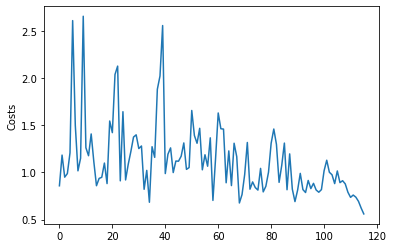

================== Initial model ==================
Train loss: 0.858, accuracy: 0.357
Test loss: 1.002, accuracy: 0.263
================== Final model ==================
Train loss: 0.560, accuracy: 0.821
Test loss: 0.587, accuracy: 0.842
Duration: 3.356 s


In [139]:
def plot(costs, temperatures):
  plt.plot(costs)
  plt.ylabel('Costs')
  plt.show()

plot(costs, temperatures)
print('================== Initial model ==================')
evaluate_model_state(initial_weights)
print('================== Final model ==================')
evaluate_model_state(states[-1])
print('=================================================')
print(f'Duration: {(finish_time - start_time):.3f} s')

## Using backpropagation

### Train

In [143]:
model.set_weights(initial_weights)
start_time = time.time()
model.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=num_steps-1, shuffle=False)
finish_time = time.time()
final_weights = model.get_weights()

Train on 84 samples
Epoch 1/917
84/84 [==============================] - 0s 40us/sample - loss: 0.8581 - acc: 0.3571
Epoch 2/917
84/84 [==============================] - 0s 28us/sample - loss: 0.8569 - acc: 0.3571
Epoch 3/917
84/84 [==============================] - 0s 21us/sample - loss: 0.8557 - acc: 0.3571
Epoch 4/917
84/84 [==============================] - 0s 20us/sample - loss: 0.8546 - acc: 0.3571
Epoch 5/917
84/84 [==============================] - 0s 22us/sample - loss: 0.8534 - acc: 0.3571
Epoch 6/917
84/84 [==============================] - 0s 23us/sample - loss: 0.8523 - acc: 0.3571
Epoch 7/917
84/84 [==============================] - 0s 21us/sample - loss: 0.8512 - acc: 0.3571
Epoch 8/917
84/84 [==============================] - 0s 20us/sample - loss: 0.8501 - acc: 0.3571
Epoch 9/917
84/84 [==============================] - 0s 20us/sample - loss: 0.8490 - acc: 0.3571
Epoch 10/917
84/84 [==============================] - 0s 21us/sample - loss: 0.8479 - acc: 0.3571
Epoch 11/

### Evaluate

In [144]:
print('================== Initial model ==================')
evaluate_model_state(initial_weights)
print('================== Final model ==================')
evaluate_model_state(final_weights)
print('=================================================')
print(f'Duration: {(finish_time - start_time):.3f} s')

================== Initial model ==================
Train loss: 0.858, accuracy: 0.357
Test loss: 1.002, accuracy: 0.263
================== Final model ==================
Train loss: 0.516, accuracy: 0.667
Test loss: 0.543, accuracy: 0.658
Duration: 5.338 s
